# Modified Parareal Algorithm in Mixed (single and double) precision

In [1]:
# Backward Euler Method
using LinearAlgebra
function backeuler(a, b, u0::T, N) where T<:AbstractFloat
    u=Vector(undef, N+1)
    dt=(b-a)/N
    t=Vector(range(a, b, N+1))
    A=1 .- t.^2 *dt # A is Generated by Backward Euler method for du/dt=t^2 *u
    u[1]=u0
    for i in 1:N
        u[i+1]=u[i]/A[i]
    end
    return t, u
end

backeuler (generic function with 1 method)

In [2]:
# Parareal method
function parareal(a, b, u0, N, F, G, K) where T<:AbstractFloat
    # a= start time value (t0)
    # b= End time value (tend)
    # N= Number of Subinterval
    # u0=initial Solution
    # F= Fine Solver
    # G= Coarse Solver
    # K= Parareal iteration
    
    tval=Vector(range(a, b, N+1))
    # Storing Fine Solution on each time step for comparison
    Ufine=Vector{Float64}(undef, N+1)
    Ufine[1]=u0
    for i in 1:N
        Ufine[i+1]=F(tval[i], tval[i+1], Ufine[i])
    end
    # Initializing Uk
    Uk=[Vector{Float64}(undef, N+1) for k in 1:K+1]
    #Storing the initial solution
    for k in 1:K+1
        Uk[k][1]=u0
    end
    # Parareal Initialization
    for j in 1:N
        Uk[1][j+1]=G(tval[j], tval[j+1], Uk[1][j])
    end
    # Parareal loop
    δUk=[Vector{Float32}(undef, N+1) for k in 1:K+1]
    for k in 1:K
        for i in 1:N
            δUk[k][i]=Uk[k+1][i]-Uk[k][i]
            Fk0=F(tval[i], tval[i+1], Uk[k][i])
            Gk=G(tval[i], tval[i+1], δUk[k][i])
            
            Uk[k+1][i+1]=Fk0 + Gk
        end
    end
    
    return Uk, Ufine, tval, δUk
  
end

parareal (generic function with 1 method)

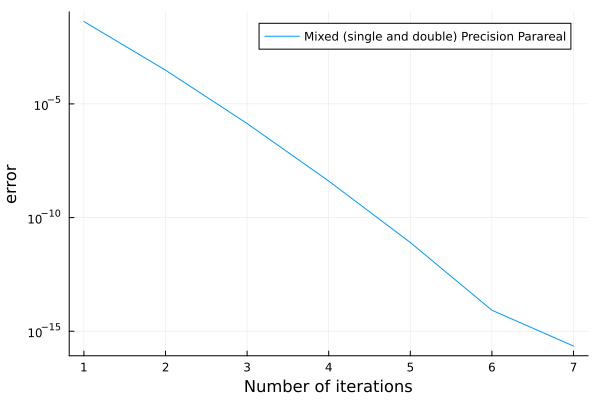

In [6]:
a=0
b=1
u0=1

#exact=exp.((t.^3)/3)


nF=100 # Fine grid
nG=2 # Coarse grid
K=6 # Number of iteration

function finesol(a, b, u0)
    t, u=backeuler(a, b, u0, nF)
    return u[end]
end
function coarsesol(a, b, u0::T) where T<:AbstractFloat
    t, u=backeuler(a, b, Float32(u0), nG)
    return u[end]
end

N=10 # Number of Subintervals

# Parareal Solution
Uk, Ufine, tval,  δUk = parareal(a, b, u0, N, finesol, coarsesol, K)

# stroing errors
    err=Vector{Float64}(undef, K+1)
    for k in 1:K+1
        err[k]=norm(Uk[k]-Ufine)
    end
using Plots
plot(err, yaxis=:log, xlabel="Number of iterations", ylabel="error", label="Mixed (single and double) Precision Parareal")

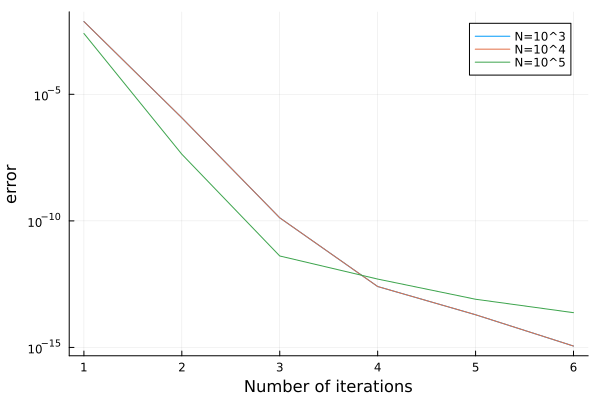

In [4]:
#convergence Analysis with multiple N's

a=0
b=1
u0=1

#exact=exp.((t.^3)/3)


nF=50 # Fine grid
nG=1# Coarse grid
K=5 # Number of iteration

function finesol(a, b, u0::T) where T<:AbstractFloat
    t, u=backeuler(a, b, Float64(u0), nF)
    return u[end]
end
function coarsesol(a, b, u0::T) where T<:AbstractFloat
    t, u=backeuler(a, b, Float32(u0), nG)
    return u[end]
end

# Convergence Analysis
p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(10^(i+2)))
end

err=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval=parareal(a, b, u0, convert(Int, N[i]), finesol, coarsesol, K)

    # stroing errors
    
    for k in 1:K+1
        err[i, k]=norm(Uk[k]-Ufine)
    end

end

using Plots
plot(err[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=10^3")
for j in 1:2
    plot!(err[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=10^$(j+3)")
end
display(plot!(legend=:topright))